## Project Summary

### Goals
Use naive Bayes classification methods to attempt to classify Amazon reviews into their original product genre. 

### Data
Our data consists of raw Amazon reviews from various product genres ([source](https://nijianmo.github.io/amazon/index.html)). We use 5-core datasets; where each item and user have 5 reviews apiece to have some measure of consistency.

### Target Insights
We're curious as to how the naive Bayes classification performs when we restrict the vocabulary size hyperparameter. Thus we run the fitting and prediction loop for several hyperparameter values and observe the validation classification accuracy.

Additionally, we chose to observe what words are most common in the positive-sentiment and negative-sentimint classes of each kind of genre. We observe the relative frequencies of relevant words in the pie charts at the bottom of this notebook.


In [ ]:
import pandas as pd
import pyspark
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import os
import re
import string

from pyspark.sql import SparkSession
from pyspark.sql.functions import lit, col, rand
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, BooleanType, MapType

from pyspark.ml.feature import Tokenizer, HashingTF, IDF, StopWordsRemover, StringIndexer
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator
import pyspark.sql.functions as f

from typing import Sequence
import matplotlib.pyplot as plt


In [ ]:
aws_bucket_name = "msds-694-groupproject-4-0"

In [ ]:
dbutils.fs.ls("s3://msds-694-groupproject-4-0/")

[FileInfo(path='s3://msds-694-groupproject-4-0/Books_5.json', name='Books_5.json', size=22361866685, modificationTime=1701467563000),
 FileInfo(path='s3://msds-694-groupproject-4-0/Clothing_Shoes_and_Jewelry_5.json', name='Clothing_Shoes_and_Jewelry_5.json', size=5088375908, modificationTime=1701450867000),
 FileInfo(path='s3://msds-694-groupproject-4-0/Electronics_5.json', name='Electronics_5.json', size=4186359340, modificationTime=1701450867000),
 FileInfo(path='s3://msds-694-groupproject-4-0/Home_and_Kitchen_5.json', name='Home_and_Kitchen_5.json', size=3480167832, modificationTime=1701450867000),
 FileInfo(path='s3://msds-694-groupproject-4-0/Movies_and_TV_5.json', name='Movies_and_TV_5.json', size=2493664111, modificationTime=1701450867000),
 FileInfo(path='s3://msds-694-groupproject-4-0/fox_stork_story.txt', name='fox_stork_story.txt', size=1314, modificationTime=1701450867000),
 FileInfo(path='s3://msds-694-groupproject-4-0/random_sample_final.json', name='random_sample_final.j

In [ ]:
rdd = spark.sparkContext.textFile("s3://msds-694-groupproject-4-0/fox_stork_story.txt")

rdd.glom().collect()

[['The Fox one day thought of a plan to amuse himself at the expense of the Stork, at whose odd appearance he was always laughing.',
  '',
  '"You must come and dine with me today," he said to the Stork, smiling to himself at the trick he was going to play. The Stork gladly accepted the invitation and arrived in good time and with a very good appetite.',
  '',
  'For dinner the Fox served soup. But it was set out in a very shallow dish, and all the Stork could do was to wet the very tip of his bill. Not a drop of soup could he get. But the Fox lapped it up easily, and, to increase the disappointment of the Stork, made a great show of enjoyment.',
  '',
  'The hungry Stork was much displeased at the trick, but he was a calm, even-tempered fellow and saw no good in flying into a rage. Instead, not long afterward, he invited the Fox to dine with him in turn. The Fox arrived promptly at the time that had been set, and the Stork served a fish dinner that had a very appetizing smell. But it 

In [ ]:
spark


## Data Imports

In [ ]:
spark = SparkSession.builder.appName("MyApp").getOrCreate()
schema = StructType([
    StructField("asin", StringType(), True),
    StructField("overall", DoubleType(), True),
    StructField("reviewText", StringType(), True),
    StructField("reviewTime", StringType(), True),
    StructField("reviewerID", StringType(), True),
    StructField("reviewerName", StringType(), True),
    StructField("style", MapType(StringType(), StringType()), True),
    StructField("summary", StringType(), True),
    StructField("unixReviewTime", StringType(), True),
    StructField("verified", BooleanType(), True),
])
df_movie = spark.read.schema(schema).json('s3://msds-694-groupproject-4-0/Electronics_5.json', multiLine=False).withColumn('label', lit('movie'))
df_movie.show(1, truncate=True, vertical=True)

-RECORD 0------------------------------
 asin           | 0151004714           
 overall        | 5.0                  
 reviewText     | This is the best ... 
 reviewTime     | 09 18, 1999          
 reviewerID     | AAP7PPBU72QFM        
 reviewerName   | D. C. Carrad         
 style          | {Format: ->  Hard... 
 summary        | A star is born       
 unixReviewTime | 937612800            
 verified       | true                 
 label          | movie                
only showing top 1 row



In [ ]:
schema = StructType([
    StructField("asin", StringType(), True),
    StructField("overall", DoubleType(), True),
    StructField("reviewText", StringType(), True),
    StructField("reviewTime", StringType(), True),
    StructField("reviewerID", StringType(), True),
    StructField("reviewerName", StringType(), True),
    StructField("style", MapType(StringType(), StringType()), True),
    StructField("summary", StringType(), True),
    StructField("unixReviewTime", StringType(), True),
    StructField("verified", BooleanType(), True),
])
df_electronics = spark.read.schema(schema).json('s3://msds-694-groupproject-4-0/Electronics_5.json', multiLine=False).withColumn('label', lit('electronics'))
df_electronics.show(1, truncate=True, vertical=True)

-RECORD 0------------------------------
 asin           | 0151004714           
 overall        | 5.0                  
 reviewText     | This is the best ... 
 reviewTime     | 09 18, 1999          
 reviewerID     | AAP7PPBU72QFM        
 reviewerName   | D. C. Carrad         
 style          | {Format: ->  Hard... 
 summary        | A star is born       
 unixReviewTime | 937612800            
 verified       | true                 
 label          | electronics          
only showing top 1 row



In [ ]:
df_book = spark.read.schema(schema).json('s3://msds-694-groupproject-4-0/Books_5.json', multiLine=False).withColumn('label', lit('books'))
df_book.show(1, truncate=True, vertical=True)

-RECORD 0------------------------------
 asin           | 0001713353           
 overall        | 5.0                  
 reviewText     | The King, the Mic... 
 reviewTime     | 03 30, 2005          
 reviewerID     | A1REUF3A1YCPHM       
 reviewerName   | TW Ervin II          
 style          | {Format: ->  Hard... 
 summary        | A story children ... 
 unixReviewTime | 1112140800           
 verified       | false                
 label          | books                
only showing top 1 row



In [ ]:
df_home = spark.read.schema(schema).json('s3://msds-694-groupproject-4-0/Home_and_Kitchen_5.json', multiLine=False).withColumn('label', lit('home'))
df_home.show(1, truncate=True, vertical=True)

-RECORD 0------------------------------
 asin           | 0560467893           
 overall        | 5.0                  
 reviewText     | Great product, lo... 
 reviewTime     | 11 5, 2015           
 reviewerID     | A8LUWTIPU9CZB        
 reviewerName   | Linda Fahner         
 style          | NULL                 
 summary        | Five Stars           
 unixReviewTime | 1446681600           
 verified       | true                 
 label          | home                 
only showing top 1 row



In [ ]:
df_cloth = spark.read.schema(schema).json('s3://msds-694-groupproject-4-0/Clothing_Shoes_and_Jewelry_5.json', multiLine=False).withColumn('label', lit('clothing'))
df_cloth.show(1, truncate=True, vertical=True)

-RECORD 0------------------------------
 asin           | 0871167042           
 overall        | 5.0                  
 reviewText     | This book has bea... 
 reviewTime     | 05 4, 2014           
 reviewerID     | A2IC3NZN488KWK       
 reviewerName   | Ruby Tulip           
 style          | {Format: ->  Pape... 
 summary        | Unique designs       
 unixReviewTime | 1399161600           
 verified       | true                 
 label          | clothing             
only showing top 1 row




## Joining and Observation

In [ ]:
df_combined = df_movie.union(df_electronics) \
                               .union(df_book) \
                               .union(df_home) \
                               .union(df_cloth)
df_combined.count()

58828582

In [ ]:
from pyspark.sql.functions import col, when

label_distribution = df_combined.groupBy("label").count().orderBy(col("count").desc())
label_distribution.show()

+-----------+--------+
|      label|   count|
+-----------+--------+
|      books|27164983|
|   clothing|11285464|
|       home| 6898955|
|      movie| 6739590|
|electronics| 6739590|
+-----------+--------+



In [ ]:
from pyspark.sql.functions import rand
spark_df = df_combined.orderBy(rand()).limit(5000)

In [ ]:
# Sample the data
df_sampled = df_combined.orderBy(rand()).limit(5000)
df_sampled = df_sampled.na.fill({'reviewText': ''})
train, val = df_sampled.randomSplit([0.8, 0.2], seed=12345)

In [ ]:
# Define the preprocessing stages
tokenizer = Tokenizer(inputCol="reviewText", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filteredWords")
idf = IDF(inputCol="rawFeatures", outputCol="features")
labelIndexer = StringIndexer(inputCol="label", outputCol="labelIndex", handleInvalid="keep")
evaluator = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction", metricName="accuracy")

In [ ]:
# Initialize the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction", metricName="accuracy")

In [ ]:
# Define hyperparameter for tuning
num_features_values = [100, 200, 300, 400, 500]
results = []


## Fitting Naive Bayes for multiple hyperparameters

In [ ]:
for num_features in num_features_values:
    # Set up the Naive Bayes model and pipeline
    hashingTF = HashingTF(inputCol="filteredWords", outputCol="rawFeatures", numFeatures=num_features)
    nb = NaiveBayes(modelType="multinomial", labelCol="labelIndex", featuresCol="features")
    pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, labelIndexer, nb])

    # Fit the model on the training set and evaluate on the validation set
    model = pipeline.fit(train)
    predictions = model.transform(val)
    accuracy = evaluator.evaluate(predictions)

    results.append((num_features, accuracy))

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]


## Visualization


Our goal was to classify the reviews into categories (books, electronics, etc.). Since there were multiple categories, this was a multiclass classification problem.
In order to solve it, we used a Multinomial Naives Bayes model, and were interested in how much the size of the vocabulary (which is an hyperparameter) would influence the classification accuracy on the validation set.

We can see that the best results (only in terms of validation accuracy) were obtained using a vocabulary size of 400, with a corresponding accuracy of approximately 60%.

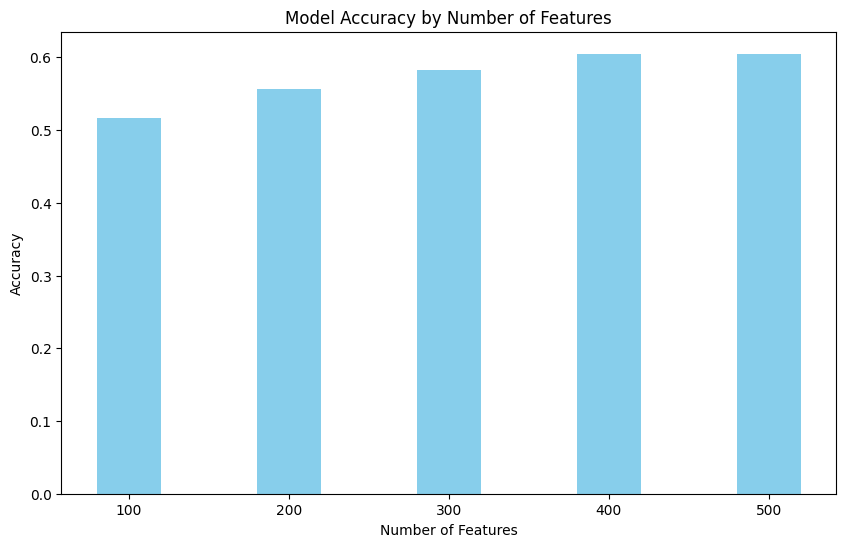

In [ ]:
num_features_list, accuracies = zip(*results)
plt.figure(figsize=(10, 6))
bar_width = 40  
plt.bar(num_features_list, accuracies, color='skyblue', width=bar_width, align='center')

plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Model Accuracy by Number of Features')
plt.xticks(num_features_list, [str(num) for num in num_features_list])
plt.show()


Since we are looking into predicting the label of the review, we first look into the most common words in each review category. The graph below is the output example for the top 25 words for the “Book” category in positive and negative reviews. As we can see, there is not a significant difference in the words used (this is not surprising)


Text(0.5, 0.98, 'Top 25 most common words in positive and negative reviews by product category')

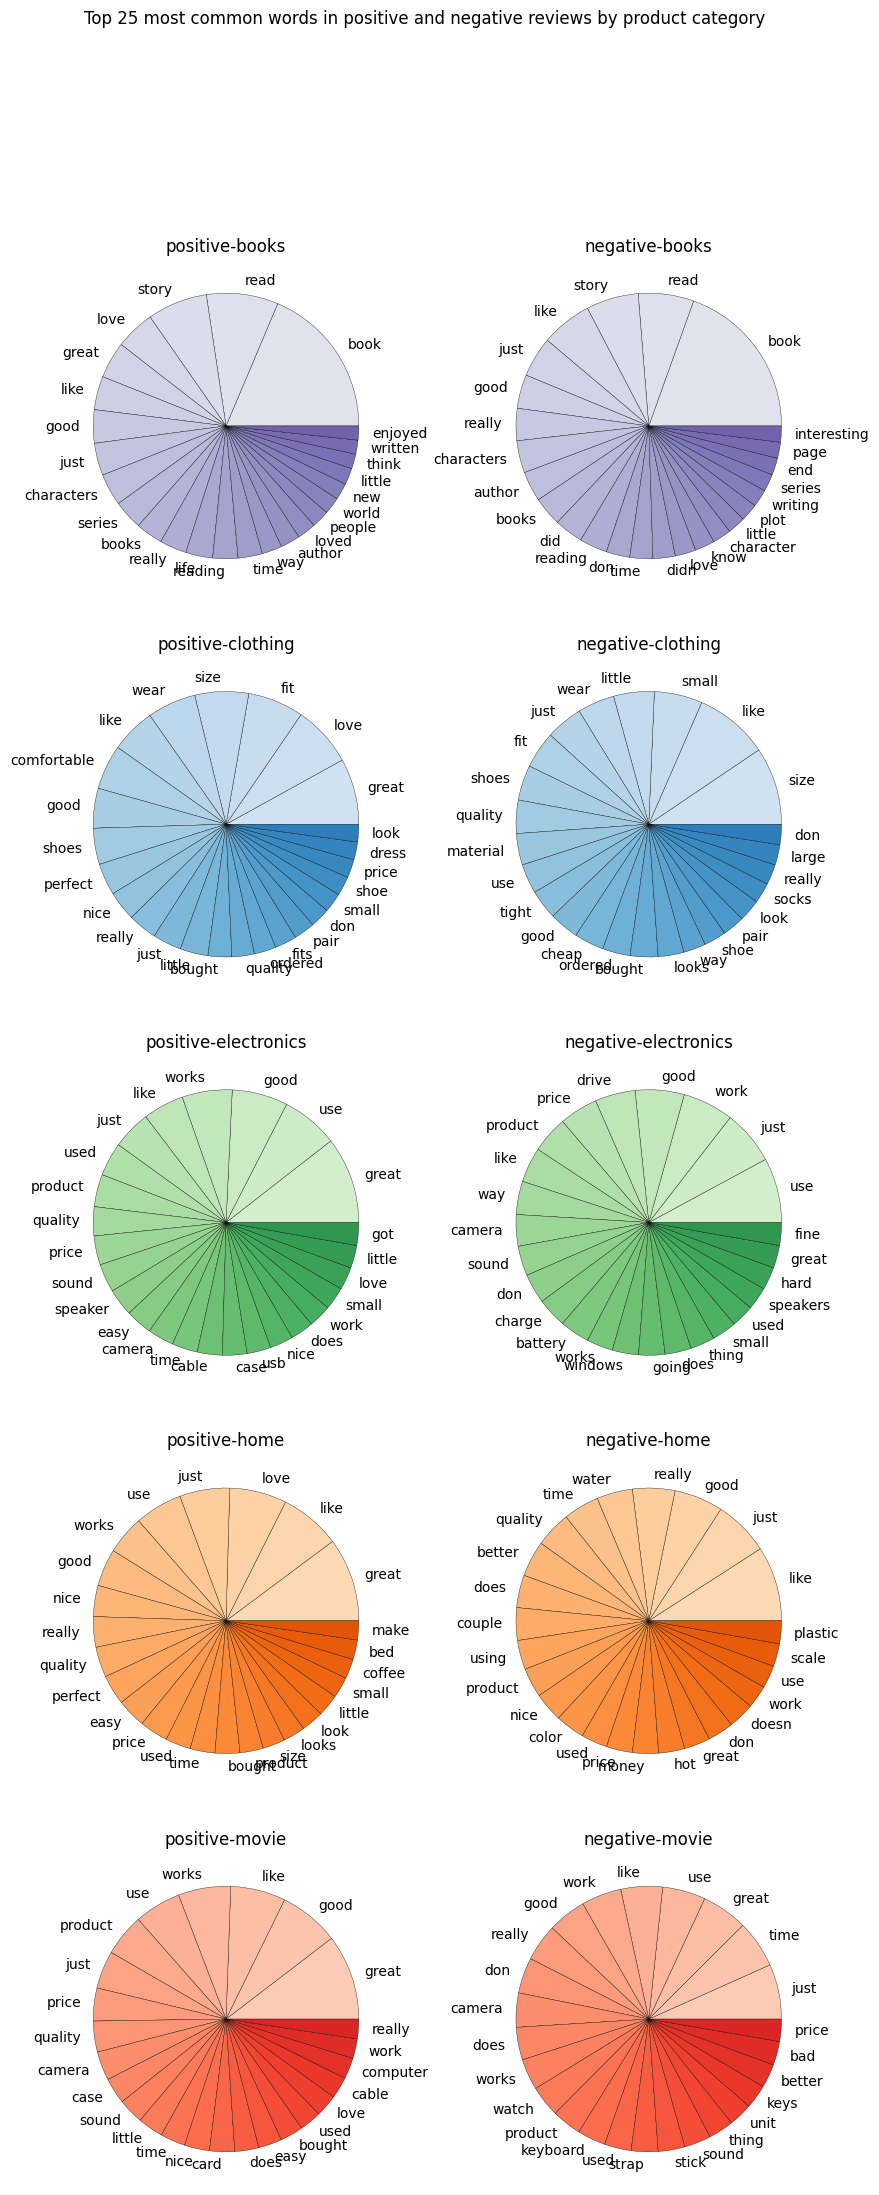

In [ ]:

ENGLISH_STOP_WORDS = frozenset([
    "a", "about", "above", "across", "after", "afterwards", "again", "against",
    "all", "almost", "alone", "along", "already", "also", "although", "always",
    "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
    "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are",
    "around", "as", "at", "back", "be", "became", "because", "become",
    "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
    "below", "beside", "besides", "between", "beyond", "bill", "both",
    "bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con",
    "could", "couldnt", "cry", "de", "describe", "detail", "do", "done",
    "down", "due", "during", "each", "eg", "eight", "either", "eleven", "else",
    "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
    "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill",
    "find", "fire", "first", "five", "for", "former", "formerly", "forty",
    "found", "four", "from", "front", "full", "further", "get", "give", "go",
    "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter",
    "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his",
    "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed",
    "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter",
    "latterly", "least", "less", "ltd", "made", "many", "may", "me",
    "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly",
    "move", "much", "must", "my", "myself", "name", "namely", "neither",
    "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone",
    "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on",
    "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our",
    "ours", "ourselves", "out", "over", "own", "part", "per", "perhaps",
    "please", "put", "rather", "re", "same", "see", "seem", "seemed",
    "seeming", "seems", "serious", "several", "she", "should", "show", "side",
    "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone",
    "something", "sometime", "sometimes", "somewhere", "still", "such",
    "system", "take", "ten", "than", "that", "the", "their", "them",
    "themselves", "then", "thence", "there", "thereafter", "thereby",
    "therefore", "therein", "thereupon", "these", "they", "thick", "thin",
    "third", "this", "those", "though", "three", "through", "throughout",
    "thru", "thus", "to", "together", "too", "top", "toward", "towards",
    "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us",
    "very", "via", "was", "we", "well", "were", "what", "whatever", "when",
    "whence", "whenever", "where", "whereafter", "whereas", "whereby",
    "wherein", "whereupon", "wherever", "whether", "which", "while", "whither",
    "who", "whoever", "whole", "whom", "whose", "why", "will", "with",
    "within", "without", "would", "yet", "you", "your", "yours", "yourself",
    "yourselves"])

def words(text:str) -> Sequence[str]:
    """
    Given a string, return a list of words normalized as follows.
    Split the string to make words first by using regex compile() function
    and string.punctuation + '0-9\\r\\t\\n]' to replace all those
    char with a space character.
    Split on space to get word list.
    Ignore words < 3 char long.
    Lowercase all words
    Remove English stop words
    """
    ctrl_chars = '\x00-\x1f'
    regex = re.compile(r'[' + ctrl_chars + string.punctuation + '0-9\r\t\n]')
    nopunct = regex.sub(" ", text)  # delete stuff but leave at least a space to avoid clumping together
    words = nopunct.split(" ")
    words = [w for w in words if len(w) > 2]  # ignore a, an, to, at, be, ...
    words = [w.lower() for w in words]
    words = [w for w in words if w not in ENGLISH_STOP_WORDS and w != '']
    
    count = {}
    for i in words:
        count[i] = count.get(i, 0) + 1
    count = sorted(count.items(), key=lambda kv:(kv[1], kv[0]),reverse=True)[:25]
    return count


word_concat = spark_df.select(col('*'),when(spark_df['overall']<=3,'negative').otherwise('positive').alias("impression"))\
                      .groupby(["impression","label"])\
                      .agg(f.concat_ws("", f.collect_list(spark_df.reviewText)).alias('reviewText'))\
                      .orderBy(["impression", "label"], ascending=[0, 1])
                                                   
words_count = word_concat.rdd.map(lambda row: ((row[0],row[1]),words(row[2])))
words_graph = words_count.collect()


fig, axs = plt.subplots(5, 2, figsize=(10, 25))
k=0
for j in range(2):
    for i in range(5):
        sizes = list(map(lambda x:x[1],words_graph[k][1]))
        labels = list(map(lambda x:x[0],words_graph[k][1]))
        colors = plt.get_cmap(['Purples', 'Blues', 'Greens', 'Oranges', 'Reds'][i])(np.linspace(0.2, 0.7, len(sizes)))
        axs[i,j].pie(sizes, labels=labels,colors=colors,wedgeprops = {"edgecolor" : "black", 'linewidth': 0.25})
        axs[i,j].set_title(f'''{words_graph[k][0][0]}-{words_graph[k][0][1]}''')
        k+=1
fig.suptitle("Top 25 most common words in positive and negative reviews by product category")
# plt.savefig('pies_words.png')



More interestingly, if we look at the most common words used across the different categories we can see that their vocabulary is different, meaning that our goal of review classification is very feasible.
